In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import scipy

%matplotlib inline

plt.style.use('ggplot')
pd.set_option('display.max_columns', 50)


import json # to work with json file format
from bs4 import BeautifulSoup

In [3]:
from src.clean_data import *

%load_ext autoreload
%autoreload 2

In [ ]:
frauds = pd.read_json('data/data.json')

In [ ]:
frauds.head()

In [ ]:
df = clean_data(frauds)

In [ ]:
df.head()

In [ ]:
fig, ax = plt.subplots(figsize=(10,6))

ax = sns.heatmap(df.corr(), annot=True);

# Feature and Label

In [ ]:
y = df['fraud'].values
X = df.drop('fraud', axis=1).values

## Model Libraries

In [131]:
import mlxtend.plotting as mlx

In [132]:
from sklearn.model_selection import train_test_split, KFold, cross_val_score
from sklearn.metrics import mean_squared_error, r2_score, roc_curve, confusion_matrix, accuracy_score, precision_score, recall_score

In [ ]:
# def coef_plot(model, data, num_splits):
#     cols = np.array(data.columns).reshape(-1,1)
#     coefs = np.round(model.coef_, 2).reshape(-1,1)
    
#     col_coefs = np.concatenate((cols, coefs), axis=1)
#     coefs_df = pd.DataFrame(col_coefs, columns=['Feature Names', 'Coefficients'])
#     coefs_df.set_index('Feature Names', inplace=True)
    
#     print(coefs_df)
    
#     coefs_df.sort_values(by='Coefficients').plot(kind='barh', figsize=(9,6))
#     plt.title(f'Feature Coefficients with {num_splits} KFolds')
#     plt.xlabel('Coefficients')
#     plt.legend(loc='lower right')

## Train Test Split

In [25]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X,y, test_size=0.2)

NameError: name 'X' is not defined

## Basic Random Forest

In [ ]:
rf = RandomForestClassifier(n_jobs=-1)
rf.fit(X_train, y_train)
pred = rf.predict(X_test)
accuracy = rf.score(X_test, y_test)

In [129]:
from sklearn.metrics import confusion_matrix

In [ ]:
basic_rf_conf

In [ ]:
basic_rf_conf = confusion_matrix(y_test, pred, labels=[False, True])
mlx.plot_confusion_matrix(conf_mat=basic_rf_conf, figsize=(8,8), class_names=[0,1]);

In [130]:
from sklearn.metrics import recall_score

In [ ]:
recall_score(y_test, pred)

## KFolds with Random Forest

In [145]:
def k_folds_models(X_data, y_data, num_splits):
    kfold = KFold(n_splits=num_splits)
    
    models = []
#     mses = []
    accuracies = []
    precisions = []
    recalls = []
    
    fprs = []
    tprs = []
    thresholds = []
    
    for train, validation in kfold.split(X_data):
        rf = RandomForestClassifier(n_estimators=90, max_features=5, n_jobs=-1, bootstrap=True)
        rf.fit(X_data[train], y_data[train])
        pred = rf.predict(X_data[validation])
        proba = rf.predict_proba(X_data[validation])
        
        #save each model to go back for reference
        models.append(rf)
        
        #mean squared error of the y_test values and the predicted
#         err = mean_squared_error(y_train[validation], pred)
#         mses.append(err)
        
        #accuracy scores
        accu = accuracy_score(y_data[validation], pred)
        accuracies.append(accu)
        
        #precision scores
        precise = precision_score(y_data[validation], pred)
        precisions.append(precise)
        
        #recall scores
        recall = recall_score(y_data[validation], pred)
        recalls.append(recall)
        
        fpr_val, tpr_val, thresholds_val = roc_curve(y_data[validation], proba[:, 1])
        
        fprs.append(fpr_val)
        tprs.append(tpr_val)
        thresholds.append(thresholds_val)
        
    return (models, accuracies, precisions, recalls, fprs, tprs, thresholds)

In [ ]:
num_splits= 10

model, accuracies, precisions, recalls, fpr, tpr, thresholds = k_folds_models(X_train, y_train, num_splits)

print(f'Random Forest with KFolds: {num_splits} \n')
print(f'     Average Accuracy Score  : {np.mean(accuracies):2.5f}')
print(f'     Average Precision Score : {np.mean(precisions):2.5f}')
print(f'     Average Recall Score    : {np.mean(recalls):2.5f}')
# print(f'     Average MSE Score       : {np.mean(mses):2.5f}')

In [ ]:
fig, ax = plt.subplots(figsize=(8,5))

for i in range(len(fpr)):
    ax.plot(fpr[i], tpr[i])
    ax.plot([0,1], [0,1], 'k--')
    ax.set_title('ROC Curve: Random Forest with 10 folds')
    
ax.set_xlabel('False Positive Rate')
ax.set_ylabel('True Positive Rate')
    
plt.savefig('images/rf_kfolds_10.png')

In [ ]:
feat_names = df.columns[1:].values

feat_importance = model[0].feature_importances_

feature_df = pd.DataFrame(feat_importance, feat_names)

feature_df.reset_index(inplace=True)

feature_df.rename(columns={'index':'feat_importance', 0:'feat_names'},inplace=True)

feature_df.sort_values('feat_names',ascending=False,inplace=True)

In [ ]:
fig, ax = plt.subplots(figsize=(15,6))

ax = sns.barplot(feature_df['feat_importance'], feature_df['feat_names'])
ax.set_title('Random Forest Feature Importances')

plt.savefig('images/rf_feat_importance.png')

## RF num trees graph

In [124]:
from tqdm import tqdm
getattr(tqdm, '_instances', {}).clear()

In [ ]:
num_trees = range(5, 150, 5)
accuracies = []
for n in tqdm(num_trees):
    tot = 0
    for i in range(5):
        rf2 = RandomForestClassifier(n_estimators=n, bootstrap=True, n_jobs=-1)
        rf2.fit(X_train, y_train)
        tot += rf2.score(X_test, y_test)
    accuracies.append(tot / 5)
fig, ax = plt.subplots()
ax.plot(num_trees, accuracies)
ax.set_xlabel("Number of Trees")
ax.set_ylabel("Accuracy")
ax.set_title('Accuracy vs Num Trees')

In [ ]:
num_features = range(1, len(df.drop('fraud', axis=1).columns) + 1)
accuracies = []
for n in tqdm(num_features):
    tot = 0
    for i in range(5):
        rf = RandomForestClassifier(n_estimators=90, max_features=n, n_jobs=-1, bootstrap=True)
        rf.fit(X_train, y_train)
        tot += rf.score(X_test, y_test)
    accuracies.append(tot / 5)
fig, ax = plt.subplots()
ax.plot(num_features, accuracies)
ax.set_xlabel("Number of Features")
ax.set_ylabel("Accuracy")
ax.set_title('Accuracy vs Num Features')

# OLS

In [1]:
from statsmodels.regression.linear_model import OLS

In [4]:
def gross_profit_dummies(x):
    '''
    Seperates the gross values by their percentiles. 
    0 being no gross profits made,
    1 being less than $75 made
    2 being less than $345 made
    3 being less than $1356 made
    4 being more than $1356 made
    '''
    if x < 1:
        return 0
    elif x < 75:
        return 1
    elif x < 345:
        return 2
    elif x < 1356:
        return 3
    else:
        return 4

def clean_data_ols(df):
    '''
    Cleans the input dataframe.
    '''
    # Create a new column called 'fraud' that contains if the account is fradulent
    frauds = set(['fraudster_event', 'fraudster', 'fraudster_att'])
    df['fraud'] = df['acct_type'].apply(lambda x: True if x in frauds else False)
    

    # Fill NA values of column 'delivery_method' with 4
    df['delivery_method'].fillna(4, inplace=True)


    # Create a new column called 'previous_payouts_length_ which will be 0
    # if the length is zero, otherwise it is 1.
    df['previous_payouts_length'] = df['previous_payouts'].apply(lambda x: len(x))
    df['previous_payouts_length_'] = df['previous_payouts_length'].apply(lambda x: 1 if x>1 else 0)

    # fb_published was found to have a high indication during eda, don't need to filter it

    # Create a new column called 'ticket_type_length' which will be True if the length of ticket_type is 0
    df['ticket_type_length'] = (df['ticket_types'].apply(lambda x: len(x)) < 1)

    ### Gross Profits ###
    # Create a new column called 'gross_profits' that multiples the cost of each ticket
    # in ticket_types by the quanitity sold. This will then be used as a dummie variable.
    gross_profits_list = []
    for row in df['ticket_types']:
        gross_profits = 0
        for i in range(len(row)):
            gross_profits += row[i]['cost'] * row[i]['quantity_sold']
        gross_profits_list.append(gross_profits)
    df['gross_profits'] = gross_profits_list

    # Create a new column called gross_profits_dummies that will use gross_profit_dummie function
    df['gross_profits_dummies'] = df['gross_profits'].apply(lambda x: gross_profit_dummies(x))

    # channels was found to have a high indiction during eda, don't need to filter it

    # user_type was found to have a high indication during eda, don't need to filter it

    # sale_duration2 was found to have a high indction during ead, don't need to filter it

    # Grab only the columns that our group found to be important
    df_cleaned = df.copy()

    return df_cleaned

In [5]:
ols_df = pd.read_json('data/data.json')

In [37]:
clean_ols = clean_data_ols(ols_df)

In [38]:
clean_ols.head()

,acct_type,approx_payout_date,body_length,channels,country,currency,delivery_method,description,email_domain,event_created,event_end,event_published,event_start,fb_published,gts,has_analytics,has_header,has_logo,listed,name,name_length,num_order,num_payouts,object_id,org_desc,org_facebook,org_name,org_twitter,payee_name,payout_type,previous_payouts,sale_duration,sale_duration2,show_map,ticket_types,user_age,user_created,user_type,venue_address,venue_country,venue_latitude,venue_longitude,venue_name,venue_state,fraud,previous_payouts_length,previous_payouts_length_,ticket_type_length,gross_profits,gross_profits_dummies
0,fraudster_event,1266062400,3852,5,US,USD,0.0,"<p><a href=""http://s432.photobucket.com/albums...",gmail.com,1262739706,1265630400,1.263110e+09,1265594400,0,0.00,0,1.0,0,y,"99 HOUR ""NO SLEEP"" SUPER BOWL CELEBRITY WEEKEN...",60,0,0,527017,,0.0,Party Starz Ent & Diverse Int'l Group,0.0,,,[],29.0,33,1,"[{'event_id': 527017, 'cost': 25.0, 'availabil...",36,1259613950,1,717 Washington Avenue,US,25.777471,-80.133433,INK Nightclub - South Beach,FL,True,0,0,False,0.00,0
1,premium,1296720000,3499,0,US,USD,1.0,"<p>Join us for a quick, one-night, community-b...",ruf.org,1293832670,1296288000,1.293833e+09,1296255600,0,868.02,0,0.0,1,n,Winthrop RUF Winter Getaway,27,23,1,786878,"<p>Since 1987, RUF has ministered to students ...",0.0,RUF at Winthrop University,12.0,RUF,CHECK,"[{'name': 'RUF', 'created': '2010-10-01 01:10:...",28.0,28,0,"[{'event_id': 786878, 'cost': 35.0, 'availabil...",149,1280942776,3,,US,32.776566,-79.930922,"The Charleston, SC area",SC,False,49,1,False,875.00,3
2,premium,1296172800,2601,8,US,USD,1.0,"<h3><span class=""subcategory""><strong>Teacher ...",pvsd.k12.ca.us,1291090956,1295740800,1.291092e+09,1295713800,0,3500.00,0,NaN,0,y,DRDP (2010) Teacher Training,28,19,4,787337,"<p><a href=""http://www.desiredresults.com"">www...",0.0,University Preparation School in collaboration...,0.0,University Preparation School,CHECK,"[{'name': 'Danielle Severn', 'created': '2010-...",54.0,54,0,"[{'event_id': 787337, 'cost': 93.51, 'availabi...",214,1272559388,3,10100 Pioneer Blvd Suite 100,US,33.944201,-118.080419,Los Angeles County Office of Education,CA,False,36,1,False,4488.48,4
3,premium,1388966400,12347,6,IE,EUR,1.0,"<p style=""margin-bottom: 1.3em; padding-bottom...",irishtabletennis.com,1360681570,1388534400,1.360683e+09,1360702800,0,1167.35,0,0.0,1,y,ITTA Affiliation 2013,21,39,16,885645,,0.0,,0.0,,ACH,"[{'name': '', 'created': '2010-11-09 01:10:15'...",0.0,0,0,"[{'event_id': 885645, 'cost': 25.0, 'availabil...",889,1283870102,3,,None,NaN,NaN,None,None,False,21,1,False,795.00,3
4,premium,1297900800,2417,11,US,USD,0.0,<p>Writers and filmmakers need to understand t...,artsandbusinesscouncil.org,1291994666,1297468800,1.291995e+09,1297440000,1,2313.15,0,0.0,0,y,Self Defense for Writers and Filmmakers: For A...,66,30,0,1114349,"<p><font face=""Arial""><font size=""2""><strong>T...",0.0,Arts & Business Council of Greater Boston,0.0,Arts and Business Council or Greater Boston,CHECK,[{'name': 'Arts and Business Council or Greate...,63.0,63,0,"[{'event_id': 1114349, 'cost': 150.0, 'availab...",35,1288984065,3,One Marina Park Drive,US,42.353848,-71.044276,Fish & Richardson,MA,False,49,1,False,2399.00,4


In [40]:
clean_ols.drop('has_header', axis=1, inplace=True)
clean_ols.dropna(inplace=True)

In [41]:
clean_ols.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 13094 entries, 0 to 14336
Data columns (total 49 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   acct_type                 13094 non-null  object 
 1   approx_payout_date        13094 non-null  int64  
 2   body_length               13094 non-null  int64  
 3   channels                  13094 non-null  int64  
 4   country                   13094 non-null  object 
 5   currency                  13094 non-null  object 
 6   delivery_method           13094 non-null  float64
 7   description               13094 non-null  object 
 8   email_domain              13094 non-null  object 
 9   event_created             13094 non-null  int64  
 10  event_end                 13094 non-null  int64  
 11  event_published           13094 non-null  float64
 12  event_start               13094 non-null  int64  
 13  fb_published              13094 non-null  int64  
 14  gts   

In [42]:
clean_ols.head()

,acct_type,approx_payout_date,body_length,channels,country,currency,delivery_method,description,email_domain,event_created,event_end,event_published,event_start,fb_published,gts,has_analytics,has_logo,listed,name,name_length,num_order,num_payouts,object_id,org_desc,org_facebook,org_name,org_twitter,payee_name,payout_type,previous_payouts,sale_duration,sale_duration2,show_map,ticket_types,user_age,user_created,user_type,venue_address,venue_country,venue_latitude,venue_longitude,venue_name,venue_state,fraud,previous_payouts_length,previous_payouts_length_,ticket_type_length,gross_profits,gross_profits_dummies
0,fraudster_event,1266062400,3852,5,US,USD,0.0,"<p><a href=""http://s432.photobucket.com/albums...",gmail.com,1262739706,1265630400,1.263110e+09,1265594400,0,0.00,0,0,y,"99 HOUR ""NO SLEEP"" SUPER BOWL CELEBRITY WEEKEN...",60,0,0,527017,,0.0,Party Starz Ent & Diverse Int'l Group,0.0,,,[],29.0,33,1,"[{'event_id': 527017, 'cost': 25.0, 'availabil...",36,1259613950,1,717 Washington Avenue,US,25.777471,-80.133433,INK Nightclub - South Beach,FL,True,0,0,False,0.00,0
1,premium,1296720000,3499,0,US,USD,1.0,"<p>Join us for a quick, one-night, community-b...",ruf.org,1293832670,1296288000,1.293833e+09,1296255600,0,868.02,0,1,n,Winthrop RUF Winter Getaway,27,23,1,786878,"<p>Since 1987, RUF has ministered to students ...",0.0,RUF at Winthrop University,12.0,RUF,CHECK,"[{'name': 'RUF', 'created': '2010-10-01 01:10:...",28.0,28,0,"[{'event_id': 786878, 'cost': 35.0, 'availabil...",149,1280942776,3,,US,32.776566,-79.930922,"The Charleston, SC area",SC,False,49,1,False,875.00,3
2,premium,1296172800,2601,8,US,USD,1.0,"<h3><span class=""subcategory""><strong>Teacher ...",pvsd.k12.ca.us,1291090956,1295740800,1.291092e+09,1295713800,0,3500.00,0,0,y,DRDP (2010) Teacher Training,28,19,4,787337,"<p><a href=""http://www.desiredresults.com"">www...",0.0,University Preparation School in collaboration...,0.0,University Preparation School,CHECK,"[{'name': 'Danielle Severn', 'created': '2010-...",54.0,54,0,"[{'event_id': 787337, 'cost': 93.51, 'availabi...",214,1272559388,3,10100 Pioneer Blvd Suite 100,US,33.944201,-118.080419,Los Angeles County Office of Education,CA,False,36,1,False,4488.48,4
4,premium,1297900800,2417,11,US,USD,0.0,<p>Writers and filmmakers need to understand t...,artsandbusinesscouncil.org,1291994666,1297468800,1.291995e+09,1297440000,1,2313.15,0,0,y,Self Defense for Writers and Filmmakers: For A...,66,30,0,1114349,"<p><font face=""Arial""><font size=""2""><strong>T...",0.0,Arts & Business Council of Greater Boston,0.0,Arts and Business Council or Greater Boston,CHECK,[{'name': 'Arts and Business Council or Greate...,63.0,63,0,"[{'event_id': 1114349, 'cost': 150.0, 'availab...",35,1288984065,3,One Marina Park Drive,US,42.353848,-71.044276,Fish & Richardson,MA,False,49,1,False,2399.00,4
5,premium,1300496400,117,6,US,USD,0.0,<p>Come join the Bluegrass Stallions as they t...,bluegrassstallions.com,1294421810,1300064400,1.294422e+09,1300053600,0,302.57,0,1,y,Bluegrass Stallions vs Rochester Razorsharks,44,14,3,1179983,<p>The Bluegrass Stallions is Central Kentucky...,0.0,Bluegrass Stallions Basketball,0.0,Bluegrass Stallions,CHECK,"[{'name': 'Bluegrass Stallions', 'created': '2...",65.0,65,1,"[{'event_id': 1179983, 'cost': 8.0, 'availabil...",299,1268579110,1,,US,38.209797,-84.558831,Georgetown College Alumni Gymnasium,KY,False,5,1,False,428.00,3


In [63]:
clean_ols[['fraud', 'user_type']].corr()

,fraud,user_type
fraud,1.000000,-0.181528
user_type,-0.181528,1.000000


In [54]:
clean_ols['listed'] = clean_ols['listed'].map({'y': 1, 'n': 0})

In [51]:
clean_ols[['fraud', 'gts']].corr()

,fraud,gts
fraud,1.000000,-0.004489
gts,-0.004489,1.000000


In [57]:
clean_ols[['fraud', 'listed']].corr()

,fraud,listed
fraud,1.000000,-0.035658
listed,-0.035658,1.000000


In [64]:
clean_ols[['gross_profits', 'gross_profits_dummie']].corr()

,previous_payouts_length,previous_payouts_length_
previous_payouts_length,1.000000,0.176086
previous_payouts_length_,0.176086,1.000000


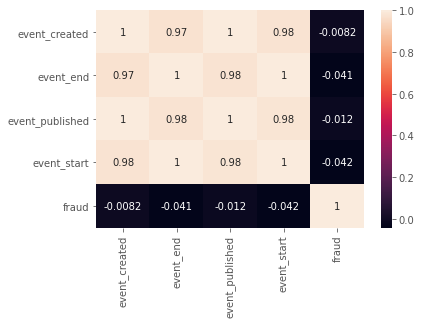

In [50]:
sns.heatmap(clean_ols[['event_created', 'event_end', 'event_published','event_start', 'fraud']].corr(), annot=True)

In [66]:
y2 = clean_ols['fraud']
X2 = clean_ols[['approx_payout_date', 'body_length', 'channels', 'event_start', 'gts', 'name_length', 'num_order',
                'num_payouts', 'has_analytics', 'has_logo',
                'delivery_method','fb_published', 'ticket_type_length', 'listed','org_twitter','org_facebook',
                'user_age', 'user_created', 'previous_payouts_length' ,'previous_payouts_length_', 'gross_profits',
                'gross_profits_dummies', 'user_type', 'sale_duration2']]

In [67]:
X2 = X2.astype(float)

In [68]:
X_train2, X_test2, y_train2, y_test2 = train_test_split(X2,y2, test_size=0.2)

In [69]:
model = OLS(y_train2, X_train2).fit()
model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                  fraud   R-squared:                    -474.050
Model:                            OLS   Adj. R-squared:               -475.141
Method:                 Least Squares   F-statistic:                    -434.5
Date:                Fri, 29 May 2020   Prob (F-statistic):               1.00
Time:                        00:05:30   Log-Likelihood:                 1337.9
No. Observations:               10475   AIC:                            -2628.
Df Residuals:                   10451   BIC:                            -2454.
Df Model:                          24                                         
Covariance Type:            nonrobust                                         
============================================================================================
                               coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------------
approx_payout_date        2.143e-09   1.06e-09      2.014      0.044    5.75e-11    4.23e-09
body_length                -1.8e-07   3.82e-07     -0.471      0.637   -9.29e-07    5.69e-07
channels                    -0.0031      0.001     -4.921      0.000      -0.004      -0.002
event_start                2.65e-08   8.51e-08      0.311      0.756    -1.4e-07    1.93e-07
gts                       4.065e-06   4.02e-07     10.117      0.000    3.28e-06    4.85e-06
name_length              -6.012e-05   9.26e-05     -0.649      0.516      -0.000       0.000
num_order                -9.359e-05    2.7e-05     -3.467      0.001      -0.000   -4.07e-05
num_payouts               7.233e-05   3.58e-05      2.023      0.043    2.25e-06       0.000
has_analytics                0.0109      0.008      1.318      0.188      -0.005       0.027
has_logo                    -0.0499      0.006     -7.991      0.000      -0.062      -0.038
delivery_method             -0.0129      0.004     -3.453      0.001      -0.020      -0.006
fb_published                -0.0362      0.006     -5.929      0.000      -0.048      -0.024
ticket_type_length           0.6215      0.213      2.912      0.004       0.203       1.040
listed                      -0.0024      0.007     -0.341      0.733      -0.016       0.011
org_twitter                 -0.0021      0.000     -5.077      0.000      -0.003      -0.001
org_facebook                -0.0014      0.000     -6.654      0.000      -0.002      -0.001
user_age                    -0.0025      0.007     -0.336      0.737      -0.017       0.012
user_created             -2.829e-08   8.51e-08     -0.332      0.740   -1.95e-07    1.39e-07
previous_payouts_length  -4.228e-05    1.9e-05     -2.223      0.026   -7.96e-05      -5e-06
previous_payouts_length_    -0.1530      0.006    -27.632      0.000      -0.164      -0.142
gross_profits            -7.296e-07   2.32e-07     -3.146      0.002   -1.18e-06   -2.75e-07
gross_profits_dummies       -0.0536      0.002    -28.556      0.000      -0.057      -0.050
user_type                   -0.0141      0.002     -9.220      0.000      -0.017      -0.011
sale_duration2              -0.0028      0.007     -0.375      0.707      -0.017       0.012
==============================================================================
Omnibus:                     4655.041   Durbin-Watson:                   2.005
Prob(Omnibus):                  0.000   Jarque-Bera (JB):            23460.371
Skew:                           2.143   Prob(JB):                         0.00
Kurtosis:                       8.949   Cond. No.                     2.38e+11
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specif

In [77]:
model.pvalues[round(model.pvalues, 5) < 0.05]

approx_payout_date           4.400659e-02
channels                     8.739290e-07
gts                          6.004605e-24
num_order                    5.281268e-04
num_payouts                  4.309963e-02
has_logo                     1.476502e-15
delivery_method              5.558164e-04
fb_published                 3.149624e-09
ticket_type_length           3.595730e-03
org_twitter                  3.891357e-07
org_facebook                 2.986892e-11
previous_payouts_length      2.622981e-02
previous_payouts_length_    2.846566e-162
gross_profits                1.658813e-03
gross_profits_dummies       9.186956e-173
user_type                    3.540046e-20
dtype: float64

In [116]:
high_cols = ['approx_payout_date', 'channels', 'gts', 'num_order', 'num_payouts',
       'has_logo', 'delivery_method', 'fb_published', 'ticket_type_length',
       'org_twitter', 'org_facebook', 'previous_payouts_length',
       'previous_payouts_length_', 'gross_profits', 'gross_profits_dummies',
       'user_type', 'fraud']

In [135]:
filter_ols = clean_ols[high_cols].copy()

In [136]:
filter_ols.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 13094 entries, 0 to 14336
Data columns (total 17 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   approx_payout_date        13094 non-null  int64  
 1   channels                  13094 non-null  int64  
 2   gts                       13094 non-null  float64
 3   num_order                 13094 non-null  int64  
 4   num_payouts               13094 non-null  int64  
 5   has_logo                  13094 non-null  int64  
 6   delivery_method           13094 non-null  float64
 7   fb_published              13094 non-null  int64  
 8   ticket_type_length        13094 non-null  bool   
 9   org_twitter               13094 non-null  float64
 10  org_facebook              13094 non-null  float64
 11  previous_payouts_length   13094 non-null  int64  
 12  previous_payouts_length_  13094 non-null  int64  
 13  gross_profits             13094 non-null  float64
 14  gross_

In [137]:
filter_ols = filter_ols.astype(float)

In [139]:
y3 = filter_ols['fraud'].values
X3 = filter_ols.drop('fraud', axis=1).values

In [140]:
X_train3, X_test3, y_train3, y_test3 = train_test_split(X3,y3, test_size=0.2)

100%|██████████| 29/29 [01:53<00:00,  5.49s/it]


Text(0.5, 1.0, 'Accuracy vs Num Trees')

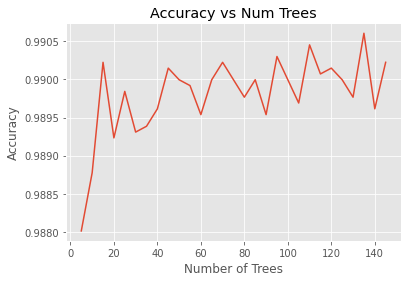

In [141]:
num_trees = range(5, 150, 5)
accuracies = []
for n in tqdm(num_trees):
    tot = 0
    for i in range(5):
        rf3 = RandomForestClassifier(n_estimators=n, bootstrap=True, n_jobs=-1)
        rf3.fit(X_train3, y_train3)
        tot += rf3.score(X_test3, y_test3)
    accuracies.append(tot / 5)
fig, ax = plt.subplots()
ax.plot(num_trees, accuracies)
ax.set_xlabel("Number of Trees")
ax.set_ylabel("Accuracy")
ax.set_title('Accuracy vs Num Trees')

In [147]:
num_splits= 10

model3, accuracies3, precisions3, recalls3, fpr3, tpr3, thresholds3 = k_folds_models(X_train3, y_train3, num_splits)

print(f'Random Forest with KFolds: {num_splits} \n')
print(f'     Average Accuracy Score  : {np.mean(accuracies3):2.5f}')
print(f'     Average Precision Score : {np.mean(precisions3):2.5f}')
print(f'     Average Recall Score    : {np.mean(recalls3):2.5f}')
# print(f'     Average MSE Score       : {np.mean(mses):2.5f}')

Random Forest with KFolds: 10 

     Average Accuracy Score  : 0.98721
     Average Precision Score : 0.94698
     Average Recall Score    : 0.84967


In [148]:
feat_names3 = filter_ols.columns[:-1].values

feat_importance3 = model3[0].feature_importances_

feature_df3 = pd.DataFrame(feat_importance3, feat_names3)

feature_df3.reset_index(inplace=True)

feature_df3.rename(columns={'index':'feat_importance', 0:'feat_names'},inplace=True)

feature_df3.sort_values('feat_names',ascending=False,inplace=True)

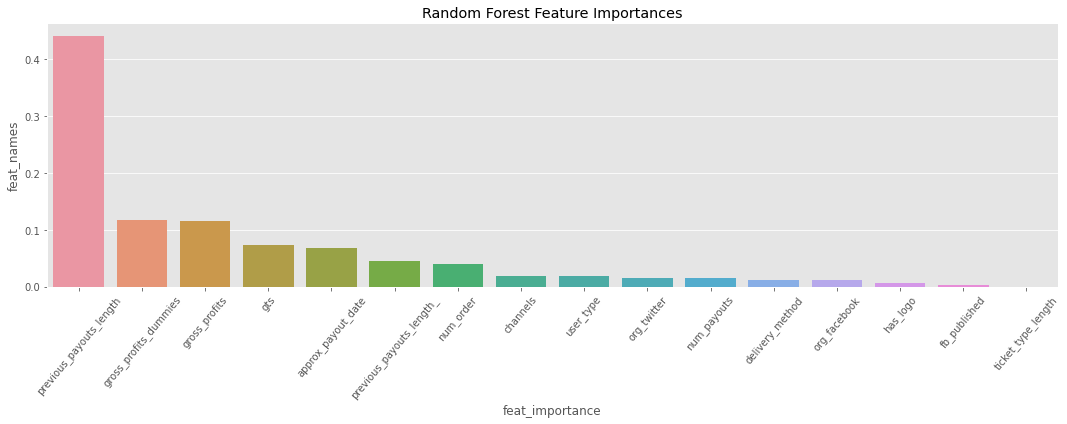

In [154]:
fig, ax = plt.subplots(figsize=(15,6))

ax = sns.barplot(feature_df3['feat_importance'], feature_df3['feat_names'])
ax.set_title('Random Forest Feature Importances')
plt.xticks(rotation=50)

plt.tight_layout()